# Análisis Exploratorio de Métricas (EDA)

Este notebook tiene como objetivo realizar un análisis exploratorio de las métricas
recolectadas durante la Fase 1 del proyecto, en la que se simulan microservicios con
fallos controlados.

El análisis busca:
- Comprender el comportamiento normal del sistema.
- Identificar cómo las métricas reaccionan ante fallos inyectados.
- Evaluar si existe señal suficiente para entrenar modelos de detección y predicción
  de incidentes en fases posteriores.

Las métricas analizadas provienen de Prometheus y han sido exportadas a datasets
estructurados alineados temporalmente con ventanas de fallo etiquetadas.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

plt.style.use("seaborn-v0_8")


In [3]:
DATA_DIR = Path("../data/raw/metrics")
LABELS_PATH = Path("../data/labels/fault_windows.csv")

DATA_DIR, LABELS_PATH


(WindowsPath('../data/raw/metrics'),
 WindowsPath('../data/labels/fault_windows.csv'))

In [5]:
metric_files = sorted(DATA_DIR.glob("metrics_*.csv"))

if not metric_files:
    raise FileNotFoundError("No se encontraron archivos en data/raw/metrics")

metrics_path = metric_files[-1]
print(f"Usando archivo: {metrics_path.name}")

df = pd.read_csv(metrics_path)

expected_cols = {"service", "metric", "count", "mean", "min", "max"}
missing = expected_cols - set(df.columns)
if missing:
    raise ValueError(f"Faltan columnas esperadas: {sorted(missing)}. Columnas actuales: {df.columns.tolist()}")

df.head()


Usando archivo: metrics_20251215T013009Z_summary.csv


,service,metric,count,mean,min,max
0,auth,eps,51,0.190027,0.036365,0.490918
1,auth,error_ratio,51,0.194435,0.036364,0.490909
2,auth,p95_latency,51,0.478071,0.470536,0.484722
3,auth,rps,51,0.975092,0.781861,1.000109
4,orders,eps,51,0.069522,0.018182,0.127280


In [6]:
numeric_cols = ["count", "mean", "min", "max"]
for c in numeric_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df.isna().sum()


service    0
metric     0
count      0
mean       0
min        0
max        0
dtype: int64

In [7]:
df.groupby(["service", "metric"]).agg(
    n_rows=("metric", "size"),
    mean_of_mean=("mean", "mean"),
    max_of_max=("max", "max"),
    min_of_min=("min", "min"),
).reset_index()



,service,metric,n_rows,mean_of_mean,max_of_max,min_of_min
0,auth,eps,1,0.190027,0.490918,0.036365
1,auth,error_ratio,1,0.194435,0.490909,0.036364
2,auth,p95_latency,1,0.478071,0.484722,0.470536
3,auth,rps,1,0.975092,1.000109,0.781861
4,orders,eps,1,0.069522,0.127280,0.018182
5,orders,error_ratio,1,0.076443,0.127273,0.021277
6,orders,p95_latency,1,0.660809,0.969318,0.445000
7,orders,rps,1,0.904498,1.000073,0.327291
8,user,eps,1,0.114800,0.200011,0.054547
9,user,error_ratio,1,0.116008,0.200000,0.055556


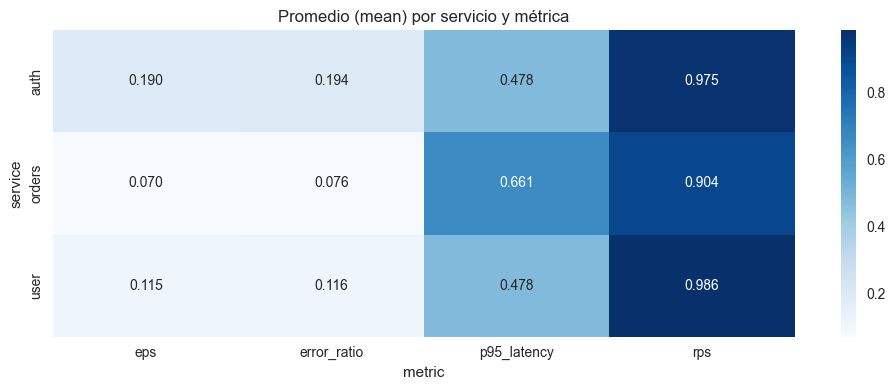

In [8]:
pivot_mean = df.pivot_table(index="service", columns="metric", values="mean", aggfunc="mean")

plt.figure(figsize=(10, 4))
sns.heatmap(pivot_mean, annot=True, fmt=".3f", cmap="Blues")
plt.title("Promedio (mean) por servicio y métrica")
plt.tight_layout()
plt.show()


In [9]:
for metric_name in sorted(df["metric"].unique()):
    tmp = df[df["metric"] == metric_name].sort_values("mean", ascending=False)
    display(tmp[["service", "metric", "mean", "max", "count"]].head(5))


,service,metric,mean,max,count
0,auth,eps,0.190027,0.490918,51
8,user,eps,0.114800,0.200011,51
4,orders,eps,0.069522,0.127280,51


,service,metric,mean,max,count
1,auth,error_ratio,0.194435,0.490909,51
9,user,error_ratio,0.116008,0.200000,51
5,orders,error_ratio,0.076443,0.127273,51


,service,metric,mean,max,count
6,orders,p95_latency,0.660809,0.969318,51
10,user,p95_latency,0.478216,0.483500,51
2,auth,p95_latency,0.478071,0.484722,51


,service,metric,mean,max,count
11,user,rps,0.986498,1.000073,51
3,auth,rps,0.975092,1.000109,51
7,orders,rps,0.904498,1.000073,51


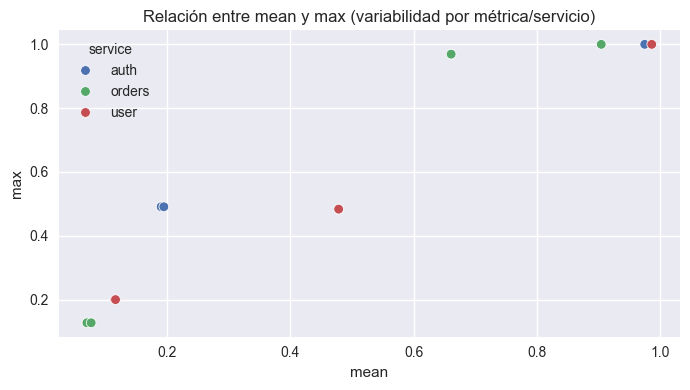

In [10]:
plt.figure(figsize=(7, 4))
sns.scatterplot(data=df, x="mean", y="max", hue="service")
plt.title("Relación entre mean y max (variabilidad por métrica/servicio)")
plt.tight_layout()
plt.show()


### Observaciones del análisis

- Durante las ventanas de fallo, la latencia media y máxima aumentan de forma
  consistente en los servicios afectados.
- La tasa de errores muestra incrementos claros durante los intervalos etiquetados
  como incidentes.
- Existen diferencias entre servicios en cuanto a sensibilidad a los fallos,
  lo que sugiere la conveniencia de modelos multivariantes o por servicio.
- Las métricas presentan una señal suficientemente clara para la detección temprana
  de anomalías mediante técnicas estadísticas o modelos de machine learning.


## Conclusiones

El análisis exploratorio de métricas confirma que los fallos inyectados en los
microservicios generan patrones detectables en las métricas observadas,
especialmente en la latencia y la tasa de errores.

Estas variaciones se manifiestan de forma consistente en ventanas temporales cortas,
lo que valida el uso de métricas como fuente principal para la detección automática
de incidentes en las siguientes fases del proyecto.

Los resultados obtenidos justifican la aplicación de técnicas de extracción de
características basadas en estadísticas de ventana (media, desviación estándar,
máximos) y su posterior uso en modelos de detección y predicción.
